**Importing the Dependencies**

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
# Define the dataset paths 
dataset_dir = 'Dataset'  
class_folders = ['with_mask', 'without_mask', 'mask_weared_incorrect']

In [4]:
# Load image files for each class
image_files = {}
for folder in class_folders:
    folder_path = os.path.join(dataset_dir, folder)
    image_files[folder] = os.listdir(folder_path)
    print(f'Number of {folder} images:', len(image_files[folder]))

Number of with_mask images: 2994
Number of without_mask images: 2994
Number of mask_weared_incorrect images: 2994


### Create labels
#### with_mask -> 0
#### without_mask -> 1
#### mask_weared_incorrect -> 2

In [5]:
labels = []
data = []

In [6]:
# Process images and create labels for each class
for idx, folder in enumerate(class_folders):
    folder_path = os.path.join(dataset_dir, folder)
    for img_file in image_files[folder]:
        # Add label
        labels.append(idx)
        
        # Process image
        image = Image.open(os.path.join(folder_path, img_file))
        image = image.resize((128, 128))
        image = image.convert('RGB')
        image = np.array(image)
        data.append(image)

In [7]:
# Convert to numpy arrays
X = np.array(data)
Y = np.array(labels)

**Displaying the Images**

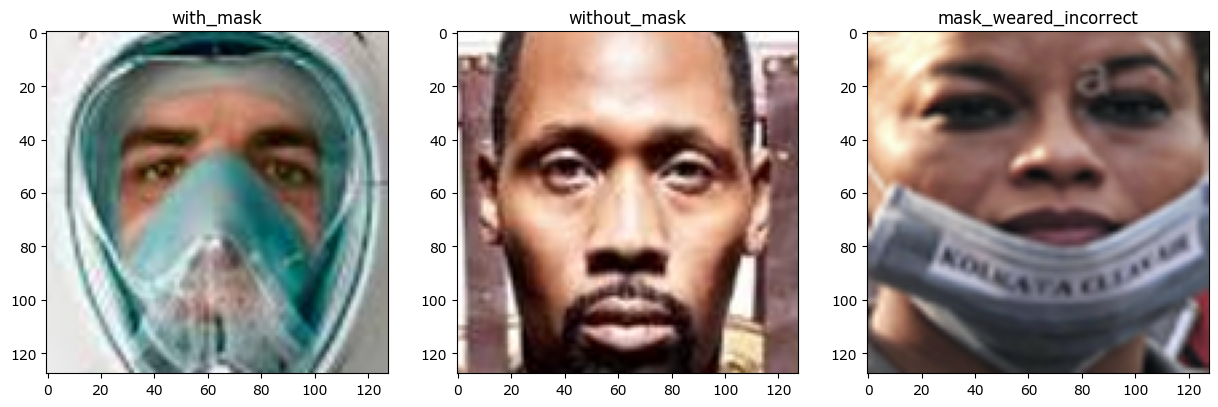

In [8]:
plt.figure(figsize=(15, 5))
for i, folder in enumerate(class_folders):
    folder_path = os.path.join(dataset_dir, folder)
    img_path = os.path.join(folder_path, image_files[folder][0])
    img = mpimg.imread(img_path)
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title(folder)
plt.show()

In [9]:
type(data)

list

**Train Test Split**

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)
print("Train and test shapes:", X_train.shape, X_test.shape)

Train and test shapes: (7185, 128, 128, 3) (1797, 128, 128, 3)


In [11]:
# Scaling the data
X_train_scaled = X_train / 255.0
X_test_scaled = X_test / 255.0

### Data Augmentation

In [12]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)
datagen.fit(X_train_scaled)

In [13]:
print("X_train original sample:", X_train[0])

X_train original sample: [[[ 44  31  23]
  [ 54  41  33]
  [ 63  50  42]
  ...
  [ 18  15  14]
  [ 11   7   6]
  [ 21  17  16]]

 [[ 39  26  18]
  [ 61  48  40]
  [ 78  65  57]
  ...
  [ 23  21  19]
  [ 17  13  12]
  [ 15  11  10]]

 [[ 36  23  15]
  [ 68  55  47]
  [ 87  74  66]
  ...
  [ 26  23  22]
  [ 22  17  17]
  [ 11   7   6]]

 ...

 [[139 134 131]
  [137 132 129]
  [133 128 125]
  ...
  [ 13  13  13]
  [ 15  15  15]
  [ 17  17  17]]

 [[137 132 129]
  [137 132 129]
  [134 129 126]
  ...
  [ 12  12  12]
  [ 15  15  15]
  [ 18  18  18]]

 [[135 130 127]
  [137 132 129]
  [136 131 128]
  ...
  [ 10  10  10]
  [ 15  15  15]
  [ 18  18  18]]]


In [14]:
print("X_train scaled sample:", X_train_scaled[0])

X_train scaled sample: [[[0.17254902 0.12156863 0.09019608]
  [0.21176471 0.16078431 0.12941176]
  [0.24705882 0.19607843 0.16470588]
  ...
  [0.07058824 0.05882353 0.05490196]
  [0.04313725 0.02745098 0.02352941]
  [0.08235294 0.06666667 0.0627451 ]]

 [[0.15294118 0.10196078 0.07058824]
  [0.23921569 0.18823529 0.15686275]
  [0.30588235 0.25490196 0.22352941]
  ...
  [0.09019608 0.08235294 0.0745098 ]
  [0.06666667 0.05098039 0.04705882]
  [0.05882353 0.04313725 0.03921569]]

 [[0.14117647 0.09019608 0.05882353]
  [0.26666667 0.21568627 0.18431373]
  [0.34117647 0.29019608 0.25882353]
  ...
  [0.10196078 0.09019608 0.08627451]
  [0.08627451 0.06666667 0.06666667]
  [0.04313725 0.02745098 0.02352941]]

 ...

 [[0.54509804 0.5254902  0.51372549]
  [0.5372549  0.51764706 0.50588235]
  [0.52156863 0.50196078 0.49019608]
  ...
  [0.05098039 0.05098039 0.05098039]
  [0.05882353 0.05882353 0.05882353]
  [0.06666667 0.06666667 0.06666667]]

 [[0.5372549  0.51764706 0.50588235]
  [0.5372549  

**Building a Convolutional Neural Networks (CNN)**

In [15]:
num_of_classes = 3
model = keras.Sequential([
    keras.layers.Input(shape=(128, 128, 3)),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),  # Added another Conv2D layer
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),  # Increased neurons
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_of_classes, activation='softmax')  # Changed to 3 classes
])

In [16]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [17]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

In [18]:
# Create validation split
X_train_part, X_val, Y_train_part, Y_val = train_test_split(X_train_scaled, Y_train, test_size=0.1, random_state=2)

In [19]:
history = model.fit(
    datagen.flow(X_train_part, Y_train_part, batch_size=32),
    validation_data=(X_val, Y_val),
    epochs=15,  
    callbacks=[early_stopping, reduce_lr]
)

C:\Users\rahul\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 117s 558ms/step - acc: 0.6052 - loss: 0.8063 - val_acc: 0.8707 - val_loss: 0.3240 - learning_rate: 0.0010
Epoch 2/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 106s 522ms/step - acc: 0.8353 - loss: 0.4447 - val_acc: 0.8971 - val_loss: 0.2641 - learning_rate: 0.0010
Epoch 3/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 106s 523ms/step - acc: 0.8701 - loss: 0.3527 - val_acc: 0.9402 - val_loss: 0.1812 - learning_rate: 0.0010
Epoch 4/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 107s 527ms/step - acc: 0.8963 - loss: 0.2921 - val_acc: 0.9166 - val_loss: 0.2159 - learning_rate: 0.0010
Epoch 5/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 115s 564ms/step - acc: 0.9056 - loss: 0.2633 - val_acc: 0.9569 - val_loss: 0.1243 - learning_rate: 0.0010
Epoch 6/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 109s 538ms/step - acc: 0.9329 - loss: 0.2052 - val_acc: 0.9694 - val_loss: 0.1018 - learning_rate: 0.0010
Epoch 7/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 124s 610ms/step - acc: 0.9358 - loss: 0.1941 - val_acc: 0.9666 - val_loss: 0.0947 - 

**Model Evaluation**

In [20]:
loss, accuracy = model.evaluate(X_test_scaled, Y_test)
print('Test Accuracy =', accuracy)

57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - acc: 0.9810 - loss: 0.0597
Test Accuracy = 0.9816360473632812


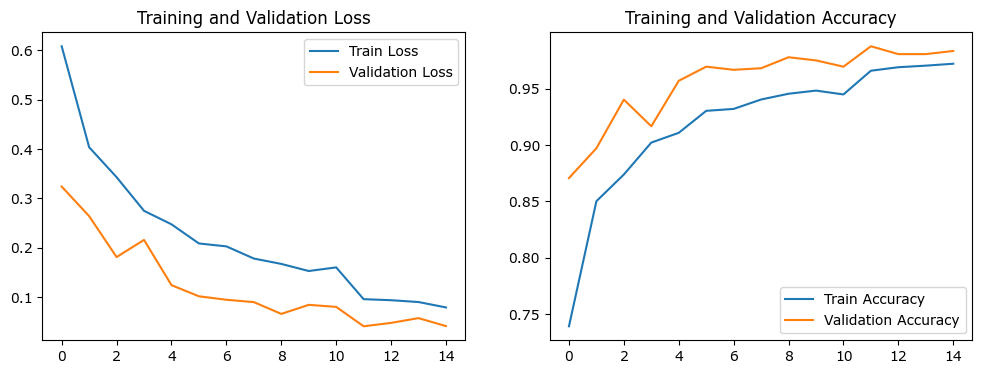

In [21]:
# Plotting loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

### Function to make predictions

In [22]:
def predict_mask(image_path):
    img = Image.open(image_path)
    img = img.resize((128, 128))
    img = img.convert('RGB')
    img = np.array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    prediction = model.predict(img)
    class_idx = np.argmax(prediction[0])
    
    return class_folders[class_idx], prediction[0][class_idx]

In [ ]:
model.save('../models/face_mask_model.keras')